In [109]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.circuit.library.raw_feature_vector import RawFeatureVector
import qiskit 
algorithm_globals.random_seed = 12345

In [110]:
qiskit.__version__

'1.1.1'

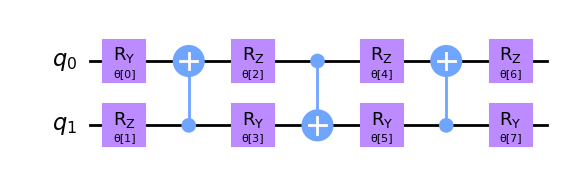

In [112]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.ry(params[0], 0) #new gate
    target.rz(params[1], 1) #was -np.pi / 2
    target.cx(1, 0)
    target.rz(params[2], 0) #was 0
    target.ry(params[3], 1) #was 1
    target.cx(0, 1)
    target.rz(params[4], 0) #new gate 
    target.ry(params[5], 1) #was 2
    target.cx(1, 0)
    target.rz(params[6], 0) #was np.pi / 2
    target.ry(params[7], 1) #new circuit
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=8) #was 3
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

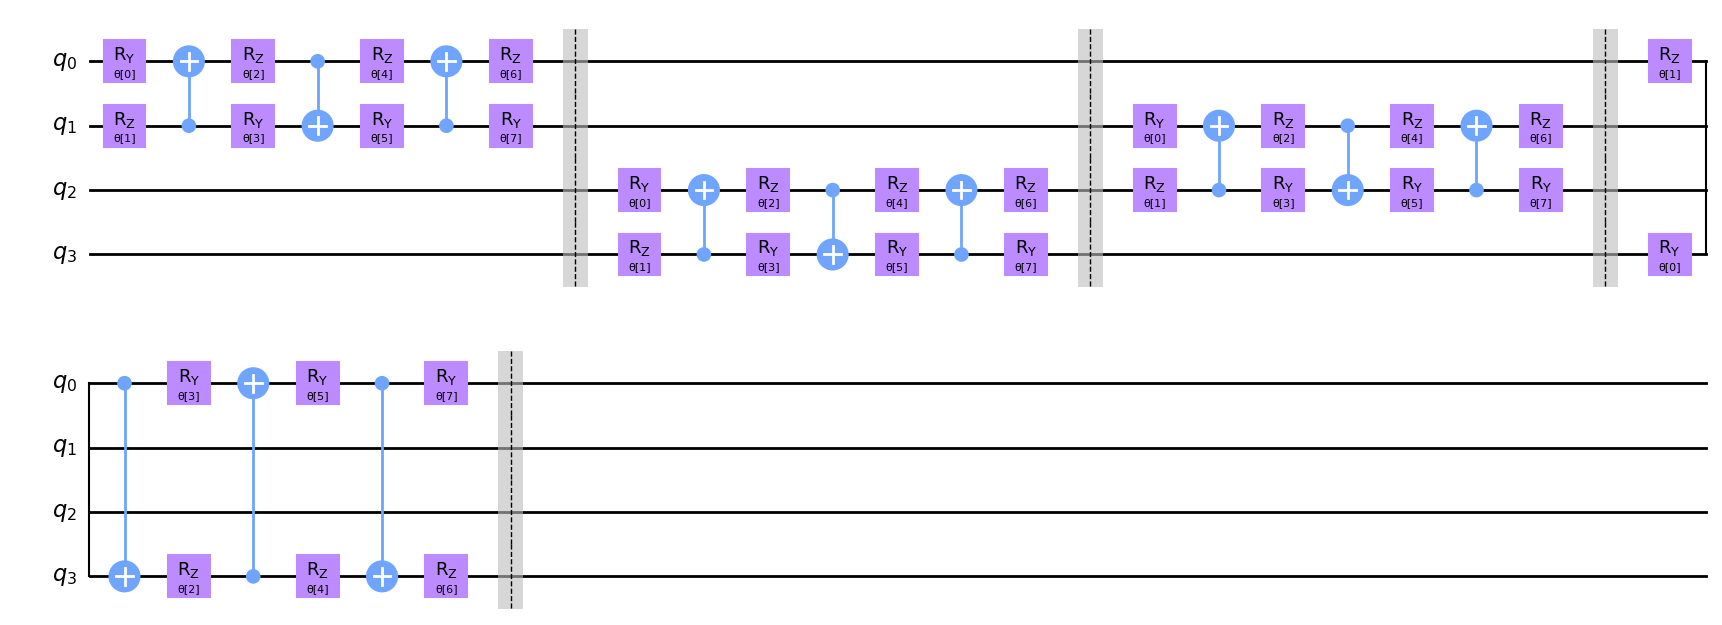

In [114]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=8) #was 3
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        # param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        # param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

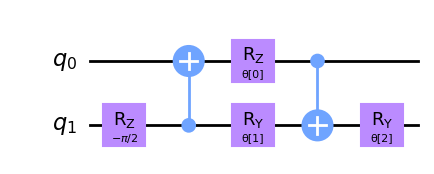

In [115]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

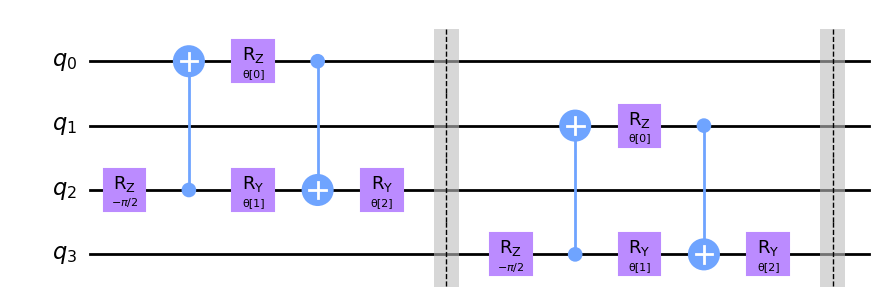

In [116]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        # param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [9]:
def generate_dataset(num_images):
    images = []
    labels = []

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 4)
        labels.append(rng)
        if rng == 0:
            images.append(np.pi / 2 * np.array([1, 0, 0, 0, 1, 0, 0, 0]))
        elif rng == 1:
            images.append(np.pi / 2 * np.array([0, 1, 0, 0, 0, 1, 0, 0]))
        elif rng == 2:
            images.append(np.pi / 2 * np.array([0, 0, 1, 0, 0, 0, 1, 0]))
        else:
            images.append(np.pi / 2 * np.array([0, 0, 0, 1, 0, 0, 0, 1]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [29]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

In [38]:
train_images[0].shape

(8,)

## REAL DATA LOADING STARTS HERE

In [117]:
import pandas as pd

In [118]:
def complex_str_to_float(complex_str):
    complex_num = complex(complex_str)
    return complex_num.real

In [119]:
SIZE = 5

In [124]:
df = pd.read_csv('train_test_df.csv')

sampled_df = df.groupby('phase').apply(lambda x: x.sample(SIZE)).reset_index(drop=True)


X_df = sampled_df.iloc[:, 10:-1]
X_df = X_df.map(complex_str_to_float)

y_df = sampled_df.iloc[:,-1]



X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)
# X_train = 

C:\Users\vokuc\AppData\Local\Temp\ipykernel_42624\54049263.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('phase').apply(lambda x: x.sample(SIZE)).reset_index(drop=True)


make sure that value counts for each phase is equal

In [126]:
y_train.value_counts()

phase
2    4
1    4
3    4
4    4
Name: count, dtype: int64

In [120]:
X_train_list = [x for x in X_train.values]
y_train_list = y_train.values
X_test_list = [x for x in X_test.values]
y_test_list = y_test.values

In [72]:
X_train_list[1].shape

(256,)

## IGNORE THIS 

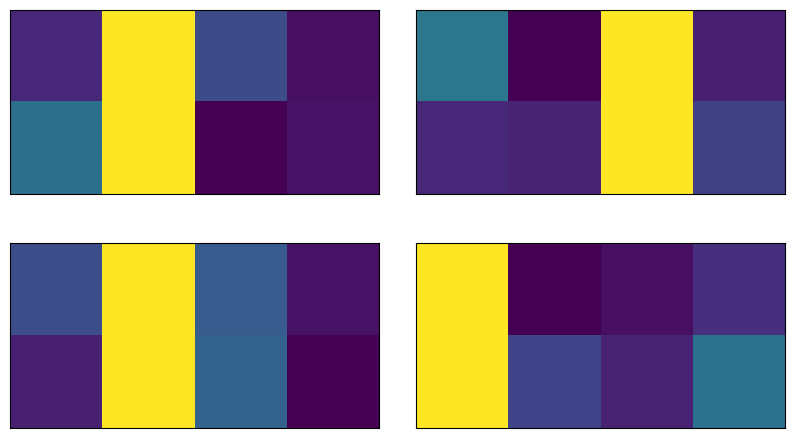

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

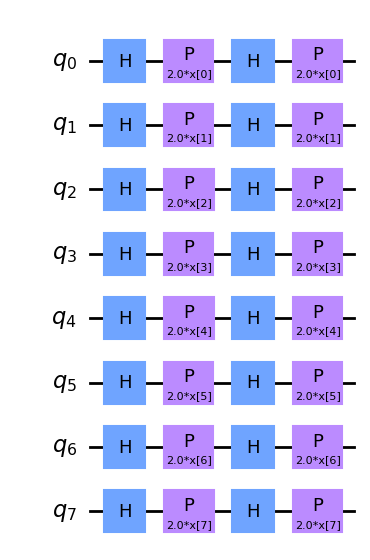

In [12]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [127]:
# from qiskit.aqua.components.feature_maps import RawFeatureVector

from qiskit_machine_learning.circuit.library.raw_feature_vector import RawFeatureVector
feature_map = RawFeatureVector(256) # ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# we decompose the circuit for the QNN to avoid additional data copying
qnn = SamplerQNN(
    circuit=circuit,#.decompose(),
    interpret=lambda measured_int: measured_int >> 6,
    output_shape=4,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [74]:
qnn.output_shape

(4,)

In [129]:
qnn.forward([X_train_list[0]], weights=np.random.rand(22)) #was 12

array([[0.20578566, 0.22142258, 0.2999395 , 0.27285226]])

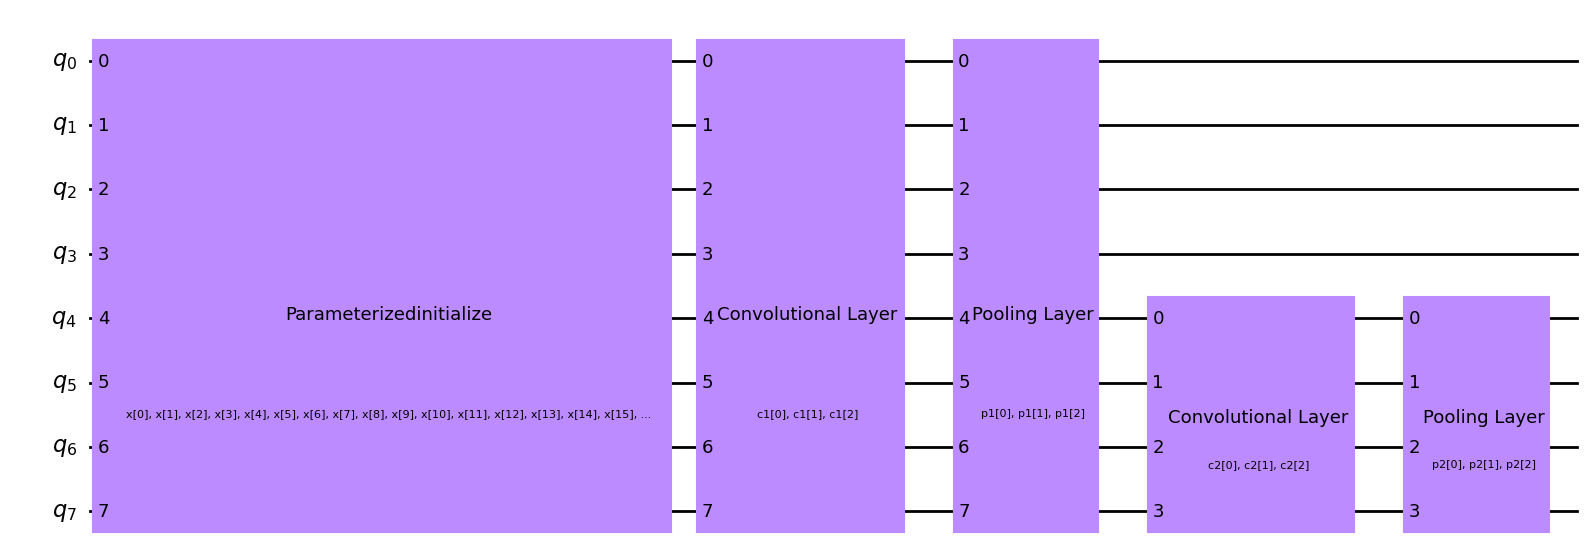

In [76]:
circuit.draw("mpl", style="clifford")

In [130]:
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

In [131]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1000),  # Set max iterations here
    callback=callback_graph,
)

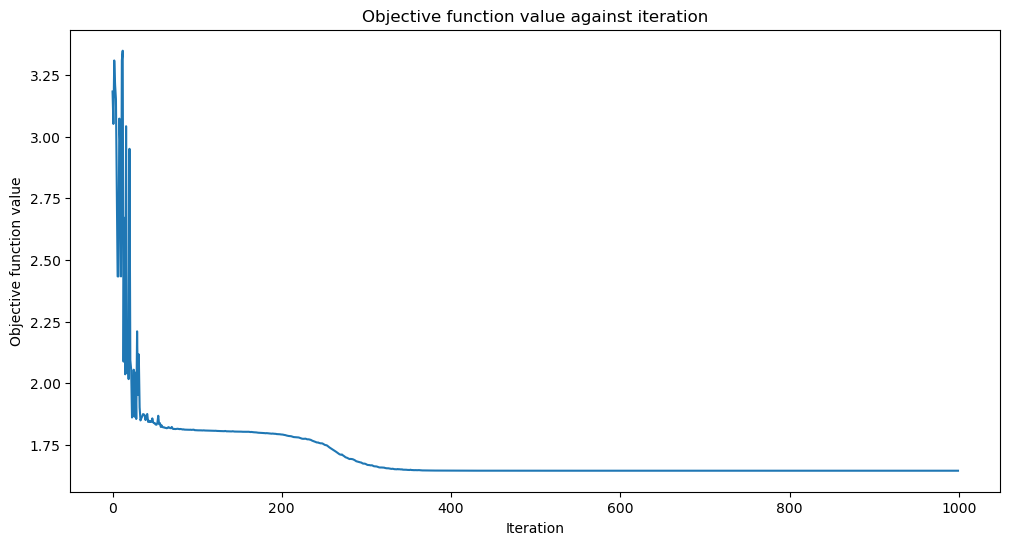

In [79]:
x = np.asarray(X_train_list)
y = np.asarray(y_train_list)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [85]:
y_test

0     1
17    4
15    4
1     1
Name: phase, dtype: int64

In [82]:
classifier.predict(X_test)

array([3, 3, 3, 1], dtype=int64)

In [102]:
import pickle as pkl
SAVE_MODEL = True
SAVE_RESULTS = True

if SAVE_MODEL:
    classifier.save("classifier.obj")
if SAVE_RESULTS:
    with open("results.pkl", 'wb') as f:
        pkl.dump(objective_func_vals, f)

In [103]:
# to load model object, set LOAD_MODEL to True
LOAD_MODEL = True
if LOAD_MODEL:
    loaded_classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=1000),  # Set max iterations here
        callback=callback_graph,
    )
    loaded_classifier.load("classifier.obj")

In [106]:
# to load result object, set LOAD_RESULTS to True
LOAD_RESULTS = True
if LOAD_RESULTS:
    with open("results.pkl", 'rb') as f:

        obj_func_vals = pkl.load(f)

In [107]:
obj_func_vals

[3.1832595231732523,
 3.0517964798662587,
 3.309273376158153,
 3.21085726430248,
 3.152744948307785,
 2.8071524414330953,
 2.4330620673927377,
 2.4330620673927377,
 3.073362229207831,
 2.973563712653086,
 2.433062067392738,
 3.309521823871638,
 3.3488713202450624,
 2.087358880677592,
 2.670842656065213,
 2.035978123156135,
 3.0424983251506212,
 2.040822555057827,
 2.155439019958444,
 2.0164196715390417,
 2.9508472169878,
 2.093148754052805,
 2.055517015317225,
 1.860622027924685,
 1.8795169360122923,
 2.054559173498097,
 1.8635626106930703,
 2.042518346323222,
 1.8546782236618853,
 2.2102714495642553,
 1.9529839112275373,
 2.116722247526595,
 1.9018789544421355,
 1.8487139730774953,
 1.8577181725956606,
 1.8645894284093063,
 1.874337285371152,
 1.873284826150746,
 1.868105242815453,
 1.8500880800685784,
 1.8675817275766617,
 1.8749038908356674,
 1.8429000196815952,
 1.847518321640087,
 1.8422096174569025,
 1.8450075374339192,
 1.8428462741677776,
 1.857105520865989,
 1.841101007494678,

## THIS IS THE END OF THE NOTEBOOK

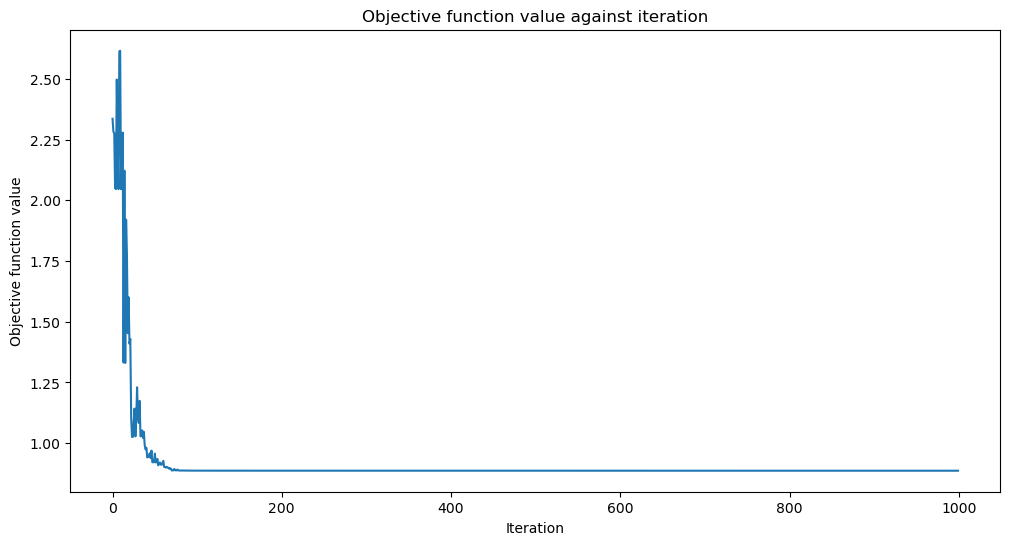

In [23]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

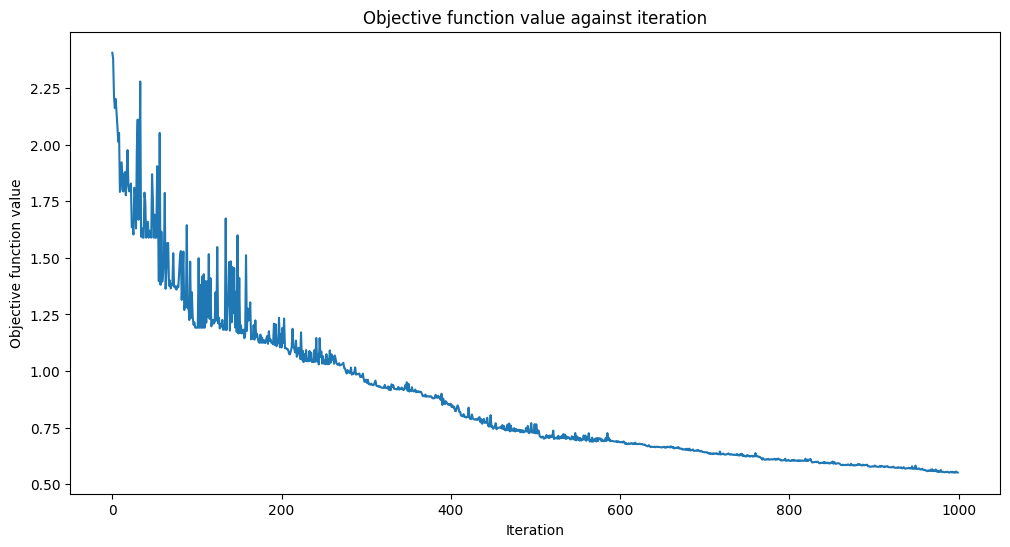

In [55]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [56]:
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data : 80.0%


In [57]:
y

array([1, 2, 1, 0, 2, 3, 2, 0, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 3, 0, 2, 2,
       0, 0, 0, 3, 3, 3, 2, 2, 1, 2, 1, 0, 1])

Accuracy from the test data : 86.67%
[0 3 0 0 0 3 2 3 2 2 2 0 2 3 2]


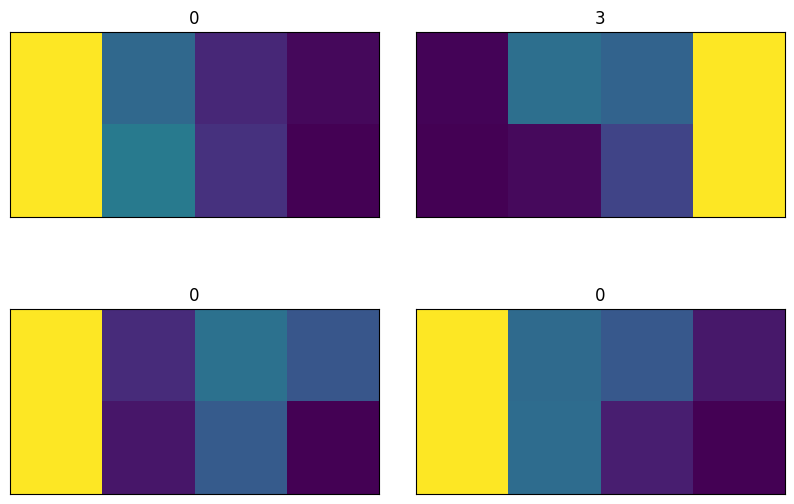

In [58]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    ax[i // 2, i % 2].set_title(y_predict[i])
plt.subplots_adjust(wspace=0.1, hspace=0.5)
print(y_predict)